
The aim of this project is to use machine learning methods to predict future stock prices and select stock portfolios. 

The data is stored in pandas DataFrames. I will only consider two columns we will use as inputs in our machine learning algorithms, both the adjusted closing price, **'Adj Close'**, and the volume of shares traded that day, **'Volume'**. These values are plotted using matplotlib's **.plot()** and **.plot.hist()** functions.

We begin our **EDA** using correlations, histograms and scatter plots, shown in code below.

To predict the raw prices of the stocks, using percentage changes makes it easier to interpret the results with stock-price predictions. The **.pct_change()** pandas function in order to calculate the percentage change in the values through a series.  

To assess correlations we use the **.corr()** function from pandas, which assumes normal distributions and measures linear correlations.

## Exploratory Data Analysis (EDA)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2020-01-02  61.119999  62.349998  61.080002  62.320000  60.416039  1712700
2020-01-03  62.320000  62.939999  62.220001  62.630001  60.716564  1580900
2020-01-06  62.750000  63.110001  62.139999  62.959999  61.036480  1558700
2020-01-07  63.000000  63.610001  62.680000  63.599998  61.656925  1710600
2020-01-08  63.939999  63.980000  61.930000  61.990002  60.096111  1955900
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02  323.540009  324.890015  322.529999  324.869995  303.135559   
2020-01-03  321.160004  323.640015  321.100006  322.410004  300.840179   
2020-01-06  320.489990  323.730011  320.3

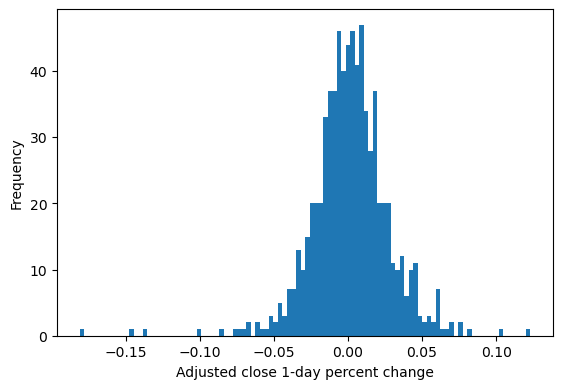

In [55]:
# Importing the yfinance api in order to get real stock data for the chosen dates.
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

lng_df = yf.download('LNG', start='2020-01-01', end='2023-01-01')
spy_df = yf.download('SPY', start='2020-01-01', end='2023-01-01')

print(lng_df.head())  # Examining the DataFrames
print(spy_df)  # Examining the SPY DataFrame

# Plotting the Adj Close columns for SPY and LNG
spy_df['Adj Close'].plot(label='SPY', legend=True)
lng_df['Adj Close'].plot(label='LNG', legend = True, secondary_y=True)
plt.show  # Showing the plot
plt.clf()  # Clearing the plot space

# Plotting histogram for the daily price change percent of Adj Close for LNG
lng_df['Adj Close'].pct_change(1).plot.hist(bins=100)
plt.xlabel('Adjusted close 1-day percent change')
plt.show()

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.032501
5d_close_future_pct     -0.032501             1.000000


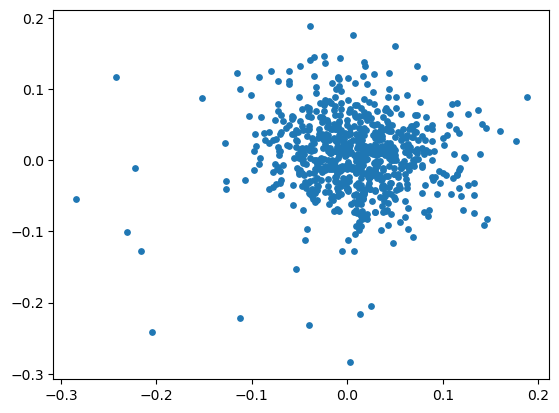

In [56]:
# Creating 5-day percentage changes of Adj Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj Close'].pct_change(5)

# Calculating the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Plotting scatter plot for the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'], s = 15)
plt.show()

## Modelling Indicators (RSI and SMA)

To prepare the data, **features** and **targets** are required. Features are inputs we predict future price changes with. This would be the 10-day price change and volume. Targets are the future price changes.

For efficiency, instead of showing all past price changes within a time period **indicators** like **moving averages** and **relative strength index** can be used in order to condense the data. 

In order to calcuate these values the **'ta-lib'** package is used, which is a wrapper for C code and provides a comprehensive collection of technical indicators.

In [57]:
import talib
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Creating moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Creating the moving average indicator and divide by Adj Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj Close'].values,timeperiod=n) / lng_df['Adj Close']
    # Creating the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj Close'].values, timeperiod=n)
    
    # Adding rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]
    
print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [58]:
# Dropping all na and blank values from lng_df dataframe
lng_df = lng_df.dropna()

# Creating features and targets for the model
# Using feature_names for features and '5d_close_future_pct' for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Creating df from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# Calculating the correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000     -0.126819  0.234844 -0.176739   
5d_close_pct                   -0.126819      1.000000 -0.840823  0.687621   
ma14                            0.234844     -0.840823  1.000000 -0.860151   
rsi14                          -0.176739      0.687621 -0.860151  1.000000   
ma30                            0.150064     -0.684309  0.884733 -0.940143   
rsi30                          -0.194316      0.546990 -0.717134  0.941098   
ma50                            0.137660     -0.551651  0.739672 -0.897550   
rsi50                          -0.214408      0.457749 -0.606837  0.847148   
ma200                           0.232136     -0.363632  0.485303 -0.698455   
rsi200                         -0.207772      0.129130 -0.145932  0.203152   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct  0.150064 -0.194316  0.137660 -0.214408  0.23213

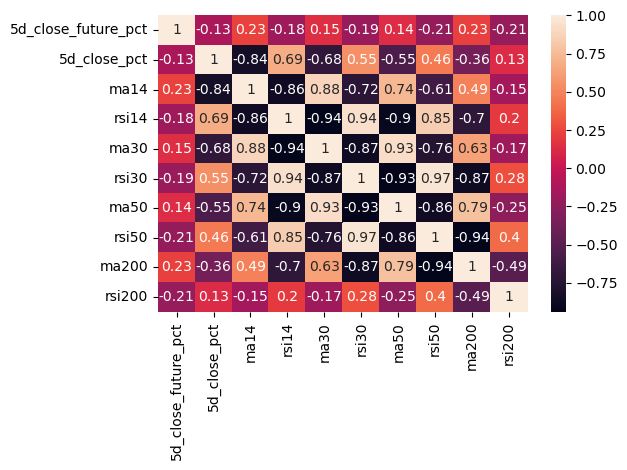

In [59]:
import seaborn as sns
# Plotting heatmap of the correlation matrix using seaborn library
sns.heatmap(corr, annot= True, annot_kws = {"size": 10})
plt.yticks(rotation=0, size = 10) # Fixing ticklabel directions and size
plt.xticks(rotation=90, size = 10)  
plt.tight_layout()  # Fitting plot area to the plot
plt.show()  # Displaying plot

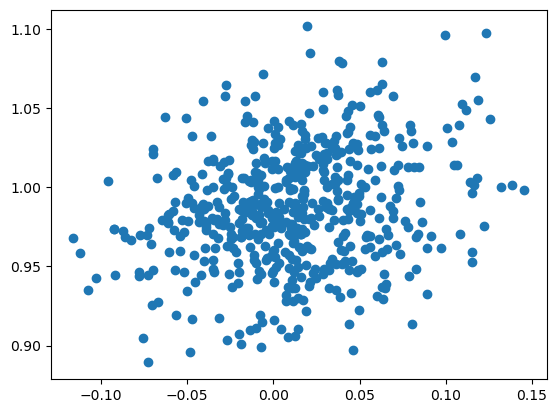

In [60]:
# Creating a scatter plot of the most highly correlated variable with the target of 5d future price
plt.scatter(lng_df['5d_close_future_pct'], lng_df['ma14'])
plt.show()

## Linear Model for features and targets to assess prediction accuracy

In [61]:
# Importing statsmodels.api library
import statsmodels.api as sm

# Adding a constant to the features 
linear_features = sm.add_constant(features)

# Creating a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])

#Using Python's '[start:stop:step]' to split the data into test and training sets
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(551, 10) (468, 10) (83, 10)


In [62]:
# Creating the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fitting the model
print(results.summary())

# examining pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Making predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.235
Model:                             OLS   Adj. R-squared:                  0.220
Method:                  Least Squares   F-statistic:                     15.62
Date:                 Wed, 14 Aug 2024   Prob (F-statistic):           2.50e-22
Time:                         21:03:16   Log-Likelihood:                 855.35
No. Observations:                  468   AIC:                            -1691.
Df Residuals:                      458   BIC:                            -1649.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.7364      0.226    

* An **R-squared** value of 1 means a perfect fit for out model and lower our R-squared value, the worse our fit is.  
* We look at **P-values** to test if the coefficients are significantly different from 0, it is the percentage chance the coefficient is actually 0.

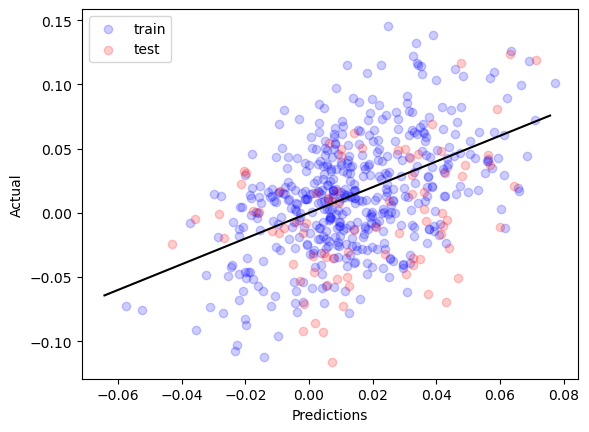

In [63]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2 , color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.legend()  # show the legend
plt.show()

We expect a point cloud result like in the plot shown above, as linear models tend to be pretty weak. 
Prediction accuracy can be significantly improved using alternative methods such as **neural networks** or **gradient boosting**.